## models download

In [ ]:
import requests
import tarfile
import sys
import os
sys.path.append("..")

In [5]:
def download_kaggle_model(model_name, model_type, url, path="../models"):
    # Download a model from Kaggle
    response = requests.get(url)
    if response.status_code == 200:
        with open(f"{path}/{model_type}/{model_name}.tar.gz", "wb") as f:
            f.write(response.content)

        # unzip the preprocessor
        with tarfile.open(f"{path}/{model_type}/{model_name}.tar.gz", "r:gz") as tar:
            tar.extractall(path=f"{path}/{model_type}/{model_name}")
            print("Preprocessor extracted successfully.")

        # remove the tar.gz file
        os.remove(f"{path}/{model_type}/{model_name}.tar.gz")
    else:
        print(f"Failed to download {model_type} model: {response.status_code}")
    

In [6]:
preprocessor_inputs = {
    "model_name": "en_uncased_preprocess",
    "model_type": "preprocessor",
    "url": "https://www.kaggle.com/api/v1/models/tensorflow/bert/tensorFlow2/en-uncased-preprocess/3/download"
}

encoder_inputs = {
    "model_name": "cmlm-en-base",
    "model_type": "encoder",
    "url": "https://www.kaggle.com/api/v1/models/google/universal-sentence-encoder/tensorFlow2/cmlm-en-base/1/download"
}

In [9]:
download_kaggle_model(**encoder_inputs)

Preprocessor extracted successfully.


## chunk embeddings

In [1]:
from rag_eval import ChunkDataHandler

import json
import tensorflow_hub as hub
import tensorflow_text as tftext
import tensorflow as tf


import sys
sys.path.append("..")

# check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")

2025-06-23 11:48:43.440490: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-23 11:48:43.480000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-23 11:48:43.534767: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-23 11:48:43.551602: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-23 11:48:43.583029: I tensorflow/core/platform/cpu_feature_guar

In [2]:
preprocessor = hub.load('../models/preprocessor/en_uncased_preprocess')

tokenizer = hub.KerasLayer(preprocessor.tokenize)
inputer = hub.KerasLayer(preprocessor.bert_pack_inputs, 
                         arguments=dict(seq_length=256)
                         )

encoder = hub.KerasLayer('../models/encoder/cmlm-en-base')

In [2]:
data_handler = ChunkDataHandler(output_path='../data')
docs_names = data_handler._evaluated_docs()

In [3]:
eval_metadata = data_handler.get_eval_file(docs_names[1])

chunks = [chunk_spec['text'] for chunk_spec in eval_metadata['chunks_eval']]
chunks_idxs = [chunk_spec['idx'] for chunk_spec in eval_metadata['chunks_eval']]
chunks_labels = tf.constant([chunk_spec['labels'] for chunk_spec in eval_metadata['chunks_eval']], tf.int32)

queries = eval_metadata['queries']

In [6]:
queries_num = len(queries)
tokenized_inputs = tokenizer(chunks + queries)
encoder_inputs = inputer([tokenized_inputs])

print(f"endoder inputs: {', '.join([key for key in encoder_inputs.keys()])}")
max_seq = tf.reduce_max(tf.reduce_sum(encoder_inputs['input_mask'], axis=1)).numpy()
print(f'Max sequence length: {max_seq}')

endoder inputs: input_type_ids, input_mask, input_word_ids
Max sequence length: 228


2025-06-23 11:36:57.724679: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


In [7]:
encoder_output = encoder(encoder_inputs)['pooled_output']
print(f"Encoder output shape: {encoder_output.shape}")

encoded_chunks = encoder_output[:-queries_num]
encoded_query = encoder_output[-queries_num:]
print(f"Encoded chunks shape: {encoded_chunks.shape}")
print(f"Encoded query shape: {encoded_query.shape}")

Encoder output shape: (74, 768)
Encoded chunks shape: (69, 768)
Encoded query shape: (5, 768)


In [8]:
encoder_inputs

{'input_type_ids': <tf.Tensor: shape=(74, 256), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(74, 256), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_word_ids': <tf.Tensor: shape=(74, 256), dtype=int32, numpy=
 array([[  101,  4456,  4062, ...,     0,     0,     0],
        [  101, 15775,  2213, ...,     0,     0,     0],
        [  101,  4015,  2000, ...,     0,     0,     0],
        ...,
        [  101,  2129,  2515, ...,     0,     0,     0],
        [  101,  2129,  2003, ...,     0,     0,     0],
        [  101,  2129,  2515, ...,     0,     0,

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

def plot_embeddings_2d(embeddings, query_embeddings=None, labels=None, idxs=None):
    """
    Reduce dimensionality of embeddings and plot them on a 2D scatter plot.

    Args:
        embeddings (np.ndarray): Encoded sentences with shape [seq_length, vector_size].
        labels (list, optional): Labels for each point in the plot (True/False). Defaults to None.
        idxs (list, optional): Indices for each point in the plot. Defaults to None.
    """
    # Reduce dimensionality to 2D using PCA
    pca = PCA(n_components=2)
    pca = pca.fit(embeddings)
    reduced_embeddings = pca.transform(embeddings)

    # Determine colors based on labels
    colors = ['green' if label else 'red' for label in tf.reduce_sum(labels, axis=-1).numpy()] if labels is not None else 'blue'

    # Create scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, alpha=0.7)
    if query_embeddings is not None:
        reduced_query = pca.transform(query_embeddings)
        plt.scatter(reduced_query[:, 0], reduced_query[:, 1], c='black', marker='x', s=100, label='Query', alpha=0.7)

    # Add indices as text if provided
    if idxs:
        for i, idx in enumerate(idxs):
            plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], str(idx), fontsize=9)

    plt.title("2D Scatter Plot of Embeddings")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

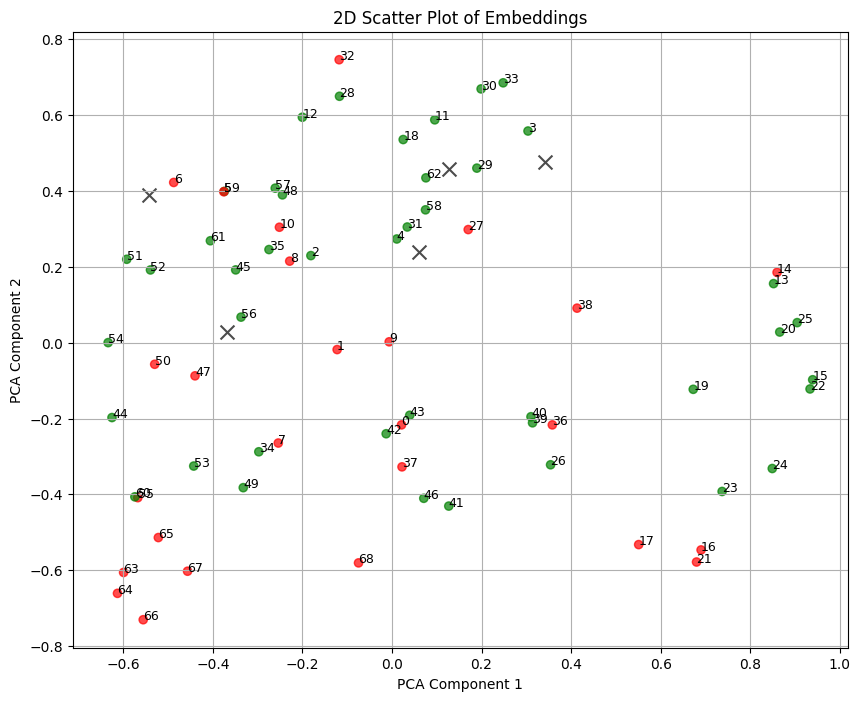

In [10]:
plot_embeddings_2d(encoded_chunks.numpy(), query_embeddings=encoded_query.numpy(), labels=chunks_labels, idxs=chunks_idxs)

In [23]:
from tensorflow_models import nlp

In [24]:
decoder = nlp.models.TransformerDecoder(
    num_layers=2,
    num_attention_heads=8,
    intermediate_size=512,
    activation='relu',
    dropout_rate=0.1,
    use_bias=False,
    norm_first=True
)

In [25]:
preds = decoder(target=encoded_chunks[tf.newaxis], memory=encoded_query[tf.newaxis])

In [26]:
preds

<tf.Tensor: shape=(1, 59, 768), dtype=float32, numpy=
array([[[-0.18762897,  1.4925135 , -0.22800732, ..., -0.5616413 ,
         -0.7349115 ,  1.0328603 ],
        [-0.2035348 ,  1.404832  , -0.05691765, ..., -0.6942688 ,
         -0.5576972 ,  1.0317388 ],
        [-0.39817438,  1.5071921 , -0.23344085, ..., -0.5442673 ,
         -0.9012772 ,  1.007411  ],
        ...,
        [-0.29286987,  1.4851685 , -0.11021481, ..., -0.8461997 ,
         -0.47414467,  1.198983  ],
        [-0.39819166,  1.5644642 , -0.14659777, ..., -0.8316036 ,
         -0.51327676,  1.0603247 ],
        [-0.15770425,  1.7321392 , -0.1994788 , ..., -0.7510547 ,
         -0.43707994,  1.0875361 ]]], dtype=float32)>

In [19]:
decoder.get_config()

{'name': 'transformer_decoder',
 'trainable': True,
 'dtype': 'float32',
 'num_layers': 6,
 'num_attention_heads': 8,
 'intermediate_size': 2048,
 'activation': 'relu',
 'dropout_rate': 0.0,
 'attention_dropout_rate': 0.0,
 'use_bias': False,
 'norm_first': True,
 'norm_epsilon': 1e-06,
 'intermediate_dropout': 0.0,
 'self_attention_cls': None,
 'cross_attention_cls': None}